In [1]:
import re
import random
import pandas as pd
import hashlib

In [2]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")
    print(F"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

if cards_to_age['age'].mean() > 80: age_factor = .5
else: age_factor = 1

cards_to_age['age'] = cards_to_age['age'].fillna(0)
# cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.60) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1/age_factor) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Azure Developer Associate']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.05

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [3]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
Azure Private DNS,90.918907,4.785206,11.024762,19
IW Migration,233.228409,46.645682,62.107002,5
RAG Project,527.182209,32.948888,46.501257,16
Todd Ideas,623.395941,103.899324,244.154929,6
Azure AD Authentication,735.358593,56.566046,111.537879,13
Azure Functions + Visual Studio,963.540209,74.118478,280.816900,13
Email Auth and Security,981.595929,81.799661,198.336118,12
Azure DevOps Pipelines,994.318260,38.243010,101.278310,26
Open Source/GitHub,1091.801115,68.237570,182.110954,16
Asynchronous Python,1178.451112,25.618502,43.312600,46


# Histogram

sum of ages: ~44726.63


<Axes: >

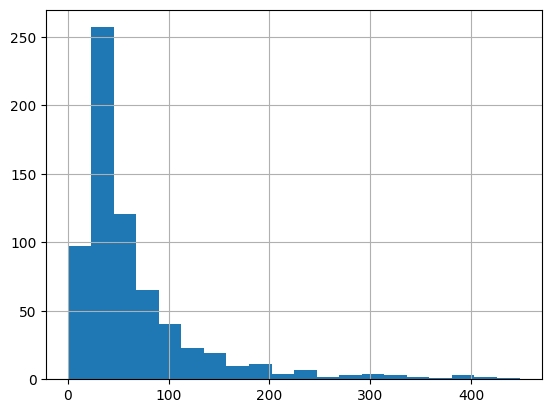

In [4]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

# Completely Random Shuffle

In [5]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [6]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# Headers with fewest notes first

In [7]:
# frequency = existing_cards['head'].value_counts(ascending=True)

# existing_cards = pd.merge(
#     left=existing_cards,
#     right=frequency.rename('frequency'),
#     left_on='head', right_index=True,
#     how='left'
# )
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] * -1
# existing_cards['age'] = existing_cards['age'] * -1


# existing_cards.sort_values(['frequency', 'subject_highest_age', 'age'], ascending=True, inplace=True)

# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

# existing_cards.head(10)

# Focus on one header

In [8]:
# heads = existing_cards['head'].value_counts()
# heads = heads[heads > 5].index.tolist()
# one_header = random.sample(heads, 1)[0]
# existing_cards['pick_head'] = existing_cards['head'].apply(
#     lambda h: 0 if h == one_header else 1 
# )

# remake_card_document(existing_cards=existing_cards.sort_values('pick_head'))

## Header with oldest cards first

In [9]:
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards.sort_values(['oldest', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest mean card age first

In [10]:
# existing_cards.sort_values(['subject_mean_age', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest age sum first

In [11]:
# existing_cards.sort_values(['subject_age_sum', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# N-fold shuffle


## Age Sum

In [12]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [13]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)



## Age Max

In [ ]:
# n = 1
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['age'] = existing_cards['age'] *-1
# # existing_cards.sort_values(['n_fold', 'subject_highest_age', 'age'], inplace=True)
# existing_cards.sort_values(['age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


Cards found: 675
Total card age: 44726.63


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold
94,Azure Developer Associate,Q: Which tiers of Azure Cache for Redis are ba...,1dfb97906449c201f5bdfcd75cba1819,-448.081152,72.718916,-448.081152,4363.134932,0.749885,0,0
325,Azure Developer Associate,Q: What are key benefits of using Redis?\nA: U...,ec6a9d42ac7d9a2d5436a6dac663fde1,-424.768161,72.718916,-448.081152,4363.134932,0.749885,1,1
141,PnP PowerShell,Server Relative URL\nThe URL path relative to ...,8cf299b28aba8eeb49c675bc6fd23204,-408.164181,56.506326,-408.164181,4068.455502,0.404796,0,0
36,Debugging in VS Code,Debugger API\nAn application programming inter...,379ed80170d7da4e8ca2e7b1a4b9527c,-397.424115,83.959118,-397.424115,1595.223235,0.346286,0,0
370,PnP PowerShell,New-PnPList (PnP.PowerShell)\nCreates a new Sh...,9d9dc3700f5078d8eaff9507709eaacb,-384.192036,56.506326,-408.164181,4068.455502,0.404796,1,1
0,Logging in Python,Q: How can you configure Python's logging to o...,293e680688510b291b7b3691786112ec,-381.998296,109.579449,-381.998296,3835.280727,0.992208,0,0
25,Audit Report Tracker (Sharepoint List),Item (SharePoint List Item)\nDefinition: A sin...,d0ce8d0da3df8f92b4ff3ca95fd426ca,-372.786634,101.909130,-372.786634,1222.909559,0.891129,0,0
47,JavaScript Concepts,Express.js: A minimalist web framework for Nod...,425c10164d26897fdad3f9d7c2c6f523,-339.079102,79.994658,-339.079102,4239.716890,0.986448,0,0
590,PnP PowerShell,AppInv.aspx\nA SharePoint page used to grant a...,ffb4c4ea52b6951b0ba17c6ec30a0956,-338.947013,56.506326,-408.164181,4068.455502,0.404796,2,2
12,WSL + Kali Linux,/etc/wsl.conf\nA configuration file in Linux d...,d7247497d7a6816591f382a140abb013,-323.011425,103.094091,-323.011425,1443.317267,0.445718,0,0


## Card Count

In [ ]:
n=10
existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] // n

if existing_cards['age'].sum() > 0:
    # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
    existing_cards['neg_age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'frequency', 'neg_age'], inplace=True)
remake_card_document(existing_cards=existing_cards)

existing_cards.head(10)


## Random

In [16]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [17]:
existing_cards.sort_values('age').head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold
94,Azure Developer Associate,Q: Which tiers of Azure Cache for Redis are ba...,1dfb97906449c201f5bdfcd75cba1819,-448.081152,72.718916,-448.081152,4363.134932,0.749885,0,0
325,Azure Developer Associate,Q: What are key benefits of using Redis?\nA: U...,ec6a9d42ac7d9a2d5436a6dac663fde1,-424.768161,72.718916,-448.081152,4363.134932,0.749885,1,1
141,PnP PowerShell,Server Relative URL\nThe URL path relative to ...,8cf299b28aba8eeb49c675bc6fd23204,-408.164181,56.506326,-408.164181,4068.455502,0.404796,0,0
36,Debugging in VS Code,Debugger API\nAn application programming inter...,379ed80170d7da4e8ca2e7b1a4b9527c,-397.424115,83.959118,-397.424115,1595.223235,0.346286,0,0
370,PnP PowerShell,New-PnPList (PnP.PowerShell)\nCreates a new Sh...,9d9dc3700f5078d8eaff9507709eaacb,-384.192036,56.506326,-408.164181,4068.455502,0.404796,1,1
0,Logging in Python,Q: How can you configure Python's logging to o...,293e680688510b291b7b3691786112ec,-381.998296,109.579449,-381.998296,3835.280727,0.992208,0,0
25,Audit Report Tracker (Sharepoint List),Item (SharePoint List Item)\nDefinition: A sin...,d0ce8d0da3df8f92b4ff3ca95fd426ca,-372.786634,101.909130,-372.786634,1222.909559,0.891129,0,0
47,JavaScript Concepts,Express.js: A minimalist web framework for Nod...,425c10164d26897fdad3f9d7c2c6f523,-339.079102,79.994658,-339.079102,4239.716890,0.986448,0,0
590,PnP PowerShell,AppInv.aspx\nA SharePoint page used to grant a...,ffb4c4ea52b6951b0ba17c6ec30a0956,-338.947013,56.506326,-408.164181,4068.455502,0.404796,2,2
12,WSL + Kali Linux,/etc/wsl.conf\nA configuration file in Linux d...,d7247497d7a6816591f382a140abb013,-323.011425,103.094091,-323.011425,1443.317267,0.445718,0,0


In [18]:
existing_cards.head(10).sum()

head                   Azure Developer AssociateAzure Developer Assoc...
body                   Q: Which tiers of Azure Cache for Redis are ba...
hash                   1dfb97906449c201f5bdfcd75cba1819ec6a9d42ac7d9a...
age                                                         -3818.452115
subject_mean_age                                              793.493256
subject_highest_age                                          -3934.95442
subject_age_sum                                             33268.084047
head_random_roll                                                6.375947
count                                                                  4
n_fold                                                                 4
dtype: object

In [19]:
existing_cards['age'].mean()

-66.26167814728166